/var/folders/7b/zk31sn6j2jd6mgfb45v946240000gn/T/ipykernel_31596/1004085464.py:22: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  thresh1 = sp.ndimage.filters.gaussian_filter(thresh1, (2,0)) #vertical gaussian blur to account for 'i', ':', etc...


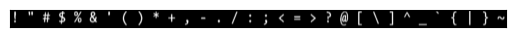

In [102]:
import cv2 as cv
import numpy as np
import scipy as sp
import os
from matplotlib import pyplot as plt

key = ['A', 'a', 'B', 'b', 'C', 'c', 'D', 'd', 'E', \
       'e', 'F', 'f', 'G', 'g', 'H', 'h', 'I', 'i', 'J', \
        'j', 'K', 'k', 'L', 'l', 'M', 'm', 'N', 'n', 'O', \
            'o', 'P', 'p', 'Q', 'q', 'R', 'r', 'S', 's', \
                'T', 't', 'U', 'u', 'V', 'v', 'W', 'w', \
                    'X', 'x', 'Y', 'y', 'Z', 'z', '!', '#', \
                    '$', '%', '&', "'", '(', ')', '*', '+', \
                        ',', '-', '.', '/', ':', ';', '<', '=', \
                            '>', '?', '@', '[', '\\', ']', 
                            '^', '_', '`', '{', '|', '}', '~']

def get_characters(image, folder = None, offset = 0, stop = -1):
    img = cv.imread(image, cv.IMREAD_GRAYSCALE)
    plt.imshow(img,'gray',vmin=0,vmax=255)
    _, thresh1 = cv.threshold(img,127,255,cv.THRESH_BINARY_INV)
    thresh1 = sp.ndimage.filters.gaussian_filter(thresh1, (2,0)) #vertical gaussian blur to account for 'i', ':', etc...


    plt.imshow(thresh1,'gray',vmin=0,vmax=255)
    plt.xticks([]),plt.yticks([])
    contours, _ = cv.findContours(thresh1, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)


    contours = sorted(contours, key=lambda c: cv.boundingRect(c)[0])
    chars = [] 
    space = []
    for i, c in enumerate(contours):
        if (i == stop):
            break

        x, y, w, h = cv.boundingRect(c) #create bounding box per character
        char = img[y:y+h, x - 1:x + w + 1]
        chars.append(char)

        if folder != None:
            path = folder + 'char_'+ str(i + offset)+'.png'
            cv.imwrite(path, char)

        xSpace = [x, w]
        space.append(xSpace)

    return chars, space

def proccess_by_rows(image):

    img = cv.imread(image, cv.IMREAD_GRAYSCALE)
    _, thresh = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)
    thresh = sp.ndimage.filters.gaussian_filter(thresh, (2,30)) #horizontal gaussian blur to find rows of text

    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda c: cv.boundingRect(c)[1])

    rows = []
    for c in contours:
        x, y, w, h = cv.boundingRect(c)
        row = img[y:y+h, x:x+w]
        rows.append(row)
    chars = []
    space = []
    for row in rows:
        c, s = get_characters_from_row(row)
        for char in c:
            chars.append(char)
        for vals in s:
            space.append(vals)
    
    return chars, space


def get_characters_from_row(row):

    _, thresh = cv.threshold(row, 127, 255, cv.THRESH_BINARY_INV)
    thresh = sp.ndimage.filters.gaussian_filter(thresh, (2,0)) #vertical gaussian blur to account for 'i', ':', etc...

    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    contours = sorted(contours, key=lambda c: cv.boundingRect(c)[0])
    chars = []
    space = []
    for c in contours:
        x, y, w, h = cv.boundingRect(c) #create bounding box per character
        char = row[y:y+h, x - 1:x + w + 1]
        chars.append(char)
        xSpace = [x, w]
        space.append(xSpace)
    
    return chars, space



get_characters('image1.png', './bag/')
get_characters('image3.png', './bag/', 51)




#https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html
def compare(char1, char2): 
    sift = cv.SIFT_create()
    bf = cv.BFMatcher()
    
    keypoints1, descriptors1 = sift.detectAndCompute(char1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(char2, None)
    matches = bf.knnMatch(descriptors1, descriptors2, k=2) #k-best matches
    good_matches = []
    if matches is None:
        return 0
    for m, n in matches:
        if m.distance < .65 * n.distance: #?Ratio Test
            good_matches.append(m)

    similarity = len(good_matches) / max(len(keypoints1), len(keypoints2))

    return similarity

def compare_by_diff(char1, char2):
    _ , c1 = cv.threshold(char1, 127, 255, cv.THRESH_BINARY)
    _ , c2 = cv.threshold(char1, 127, 255, cv.THRESH_BINARY)

    val = cv.absdiff(char1, char2)/255
    # plt.imshow(val, cmap='gray')
    # plt.show()
    mean = cv.mean(val)[0]
    return mean

def rescale_by_height(image, target_height, method=cv.INTER_LANCZOS4):
    w = int(round(target_height * image.shape[1] / image.shape[0]))
    return cv.resize(image, (w, target_height), interpolation=method)


def rescale_by_height_and_width(image, target_height, target_width, method=cv.INTER_LANCZOS4):
    return cv.resize(image, (target_width, target_height), interpolation=method)


def best_match(img, bag):
    plt.imshow(img, cmap='grey')
    list = np.zeros(83)
    for i in range(83):
        cmp = cv.imread(('./bag/char_' + str(i) + '.png'), cv.IMREAD_GRAYSCALE)
        cmp = rescale_by_height_and_width(cmp, 720, 720)
        imgR = rescale_by_height_and_width(img, 720, 720)
        list[i] = compare_by_diff(cmp, imgR)
    return np.argmin(list), list
    

def to_text(characters, space):
    thresh = 1.04
    out = ''
    i = 0
    avg = 0

    for s in space: 
        avg += s[1]
    avg = avg / len(space)

    for char in characters:
        if (i != 0):
            currx, currw = space[i]
            prevx, prevw = space[i - 1]
            print("i: " + str(-1 *  ((prevx + prevw) - currx)) + ' V: ' + str(avg * thresh))
            if(-1 *  ((prevx + prevw) - currx) > (avg * thresh)):
                out += ' '
        out += key[best_match(char, './bag')[0]]
        i += 1
    return out

/var/folders/7b/zk31sn6j2jd6mgfb45v946240000gn/T/ipykernel_31596/1004085464.py:22: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  thresh1 = sp.ndimage.filters.gaussian_filter(thresh1, (2,0)) #vertical gaussian blur to account for 'i', ':', etc...
/var/folders/7b/zk31sn6j2jd6mgfb45v946240000gn/T/ipykernel_31596/1004085464.py:54: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  thresh = sp.ndimage.filters.gaussian_filter(thresh, (2,30)) #horizontal gaussian blur to find rows of text
/var/folders/7b/zk31sn6j2jd6mgfb45v946240000gn/T/ipykernel_31596/1004085464.py:79: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.

i: 7 V: 30.002764578833695
i: 8 V: 30.002764578833695
i: 47 V: 30.002764578833695
i: 10 V: 30.002764578833695
i: 9 V: 30.002764578833695
i: 7 V: 30.002764578833695
i: 8 V: 30.002764578833695
i: 7 V: 30.002764578833695
i: 45 V: 30.002764578833695
i: 6 V: 30.002764578833695
i: 10 V: 30.002764578833695
i: 7 V: 30.002764578833695
i: 10 V: 30.002764578833695
i: 10 V: 30.002764578833695
i: 8 V: 30.002764578833695
i: 11 V: 30.002764578833695
i: 55 V: 30.002764578833695
i: 12 V: 30.002764578833695
i: 46 V: 30.002764578833695
i: 9 V: 30.002764578833695
i: 9 V: 30.002764578833695
i: 47 V: 30.002764578833695
i: 11 V: 30.002764578833695
i: 9 V: 30.002764578833695
i: 48 V: 30.002764578833695
i: 8 V: 30.002764578833695
i: 12 V: 30.002764578833695
i: 10 V: 30.002764578833695
i: 6 V: 30.002764578833695
i: 9 V: 30.002764578833695
i: 7 V: 30.002764578833695
i: 46 V: 30.002764578833695
i: 9 V: 30.002764578833695
i: 9 V: 30.002764578833695
i: 47 V: 30.002764578833695
i: 12 V: 30.002764578833695
i: 4 V: 30

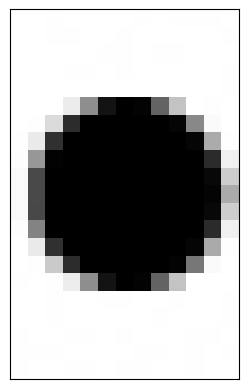

In [103]:
# t1 = cv.imread('./bag/char_9.png', cv.IMREAD_GRAYSCALE)
# t2 = cv.imread('./saved/char_7.png', cv.IMREAD_GRAYSCALE)


# t1 = rescale_by_height_and_width(t1, 720, 720)
# t2 = rescale_by_height_and_width(t2, 720, 720)

# plt.imshow(t1, cmap='gray')
# # plt.show()
# # plt.imshow(t2, cmap='gray')
# # plt.show()

test1, space1 = get_characters('image2.png')

test2, space2 = proccess_by_rows('image5.png')

# for i, t in enumerate(test1):
#     plt.imshow(t, cmap='gray')
#     plt.show()

# ind1 = best_match(t1, './bag/')
# print(ind1)

# ind2 = best_match(t2, './bag/')
# print(ind2)

# t2f = cv.GaussianBlur(t2, (27, 27), 0)
# ind2f = best_match(t2f, './bag/')
# print(ind2f)

text = to_text(test2, space2)
print(text)


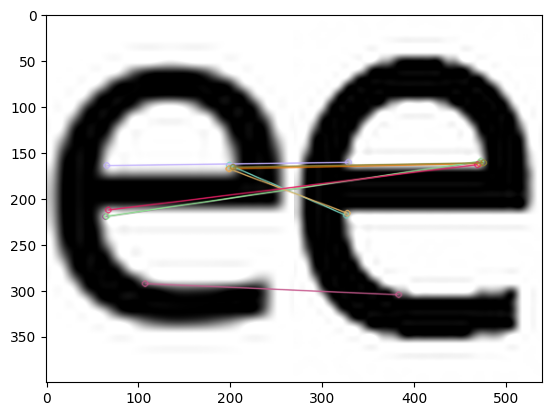

(<matplotlib.image.AxesImage at 0x177a92190>, None)

In [80]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1 = cv.imread('./bag/char_9.png',cv.IMREAD_GRAYSCALE) # queryImage
img2 = cv.imread('./saved/char_3.png',cv.IMREAD_GRAYSCALE) # trainImage
# img1 = cv.imread('./light_cubes_base',cv.IMREAD_GRAYSCALE) # queryImage
# img2 = cv.imread('./light_cubes_sm',cv.IMREAD_GRAYSCALE) # queryImage

def rescale_by_height(image, target_height, method=cv.INTER_LANCZOS4):
    """Rescale `image` to `target_height` (preserving aspect ratio)."""
    w = int(round(target_height * image.shape[1] / image.shape[0]))
    return cv.resize(image, (w, target_height), interpolation=method)

def rescale_by_height_and_width(image, target_height, target_width, method=cv.INTER_LANCZOS4):
    return cv.resize(image, (target_width, target_height), interpolation=method)


img1 = rescale_by_height_and_width(img1, 400, 270)
img2 = rescale_by_height_and_width(img2, 400, 270)

# Initiate ORB detector
orb = cv.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

/var/folders/7b/zk31sn6j2jd6mgfb45v946240000gn/T/ipykernel_31596/958572516.py:9: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  H_blur = sp.ndimage.filters.gaussian_filter(thresh1, (2,30))
/var/folders/7b/zk31sn6j2jd6mgfb45v946240000gn/T/ipykernel_31596/958572516.py:10: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  thresh1 = sp.ndimage.filters.gaussian_filter(thresh1, (2,0))


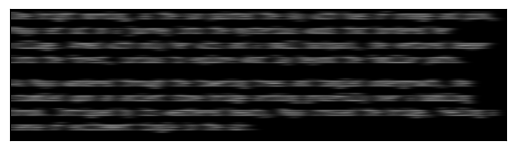

In [81]:
import cv2 as cv
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

img = cv.imread('image5.png', cv.IMREAD_GRAYSCALE)
plt.imshow(img,'gray',vmin=0,vmax=255)
_, thresh1 = cv.threshold(img,127,255,cv.THRESH_BINARY_INV)
H_blur = sp.ndimage.filters.gaussian_filter(thresh1, (2,30))
thresh1 = sp.ndimage.filters.gaussian_filter(thresh1, (2,0))


plt.imshow(H_blur,'gray',vmin=0,vmax=255)
plt.xticks([]),plt.yticks([])
contours, _ = cv.findContours(thresh1, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
rows, _ = cv.findContours(H_blur, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)


rows = sorted(rows, key=lambda c: cv.boundingRect(c)[1])
contours = sorted(contours, key=lambda c: cv.boundingRect(c)[0])
chars = []
for i, c in enumerate(contours):
    x, y, w, h = cv.boundingRect(c)

    char = img[y:y+h, x:x+w]
    chars.append(char)
    path = './saved/' + 'char_'+str(i)+'.png'
    cv.imwrite(path, char)

for i, c in enumerate(rows):
    x, y, w, h = cv.boundingRect(c)

    row = img[y:y+h, x:x+w]
    path = './saved/' + 'row_'+str(i)+'.png'
    cv.imwrite(path, row)


def rescale_by_height_and_width(image, target_height, target_width, method=cv.INTER_LANCZOS4):
    return cv.resize(image, (target_width, target_height), interpolation=method)